In [2]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
neg = open('a4-data/q2/negative.review', encoding = "ISO-8859-1")

In [4]:
raw_data = neg.read()
raw_text = raw_data.replace('\n',' ')
#type(raw_text)
pattern = r"<review_text>(.*?)</review_text>"
raw_text_new = re.findall(pattern, raw_text, flags= re.DOTALL)
print(type(raw_text_new))
data_frame = []
for i in raw_text_new:
    data_frame.append(i.lower())
df1 = pd.DataFrame(data_frame,columns = ['Review'])
df1['Label'] = 0
df1.tail()

<class 'list'>


,Review,Label
995,this book provides excellent information abou...,0
996,i really didn't enjoy this book. i am half i...,0
997,this book is a place to start at best. the m...,0
998,i was barely able to finish this book. armstr...,0
999,"""the burning"" was a big letdown after reading...",0


In [5]:
pos = open('a4-data/q2/positive.review', encoding = "ISO-8859-1")

In [6]:
raw_data1 = pos.read()
raw_text1 = raw_data1.replace('\n',' ')
#print(raw_text)
pattern = r"<review_text>(.*?)</review_text>"
raw_text_new1 = re.findall(pattern, raw_text1, flags= re.DOTALL)
#print((raw_text_new1))
data_frame = []
for i in raw_text_new1:
    data_frame.append(i.lower())
df2 = pd.DataFrame(data_frame,columns = ['Review'])
df2['Label'] = 1
df2.tail()

,Review,Label
995,"as a boy, i was fascinated by looking at all ...",1
996,this book is as much about life as it is abou...,1
997,if you are looking for ideas and techniques t...,1
998,this is a simple book to read through for you...,1
999,i wish i could give this book four and a half...,1


In [7]:
frames = [df1,df2]
data = pd.concat(frames, axis=0, sort=False,ignore_index = True)
data.shape

(2000, 2)

In [8]:
data.Label.unique()

array([0, 1])

In [9]:
pos = []
neg = []
for l in data.Label:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)

In [10]:
data['Pos']= pos
data['Neg']= neg

In [11]:
data.tail()

,Review,Label,Pos,Neg
1995,"as a boy, i was fascinated by looking at all ...",1,1,0
1996,this book is as much about life as it is abou...,1,1,0
1997,if you are looking for ideas and techniques t...,1,1,0
1998,this is a simple book to read through for you...,1,1,0
1999,i wish i could give this book four and a half...,1,1,0


In [12]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Review'].apply(lambda x: remove_punct(x))

In [13]:
from nltk import word_tokenize, WordNetLemmatizer
import nltk
nltk.download("punkt")
tokens = [word_tokenize(sen) for sen in data.Text_Clean]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aviratbelekar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [15]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [16]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [17]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens]

In [18]:
result = [' '.join(sen) for sen in filtered_words]

In [19]:
data['Text_Final'] = result

In [20]:
data['tokens'] = filtered_words

In [21]:
data = data[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg']]

In [22]:
data[:4]

,Text_Final,tokens,Label,Pos,Neg
0,book good points anything helps put words want...,"[book, good, points, anything, helps, put, wor...",0,0,1
1,fatalistic view conservativism expressed kirk ...,"[fatalistic, view, conservativism, expressed, ...",0,0,1
2,intrigued title supposedly links jedi wisdom c...,"[intrigued, title, supposedly, links, jedi, wi...",0,0,1
3,admit havent finished book friend recommended ...,"[admit, havent, finished, book, friend, recomm...",0,0,1


In [23]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)

In [24]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

148577 words total, with a vocabulary size of 23624
Max sentence length is 2827


In [25]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

15588 words total, with a vocabulary size of 5605
Max sentence length is 404


In [26]:
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path,binary=True)

In [27]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [28]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [29]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

In [30]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 23624 unique tokens.


In [31]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [32]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(23625, 300)


In [33]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [34]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [1,2]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=50, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [35]:
label_names = ['Pos', 'Neg']

In [36]:
y_train = data_train[label_names].values

In [37]:
x_train = train_cnn_data
y_tr = y_train

In [38]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      7087500     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 50)       15050       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 49, 50)       30050       embedding_1[0][0]                
____________________________________________________________________________________________

In [39]:
num_epochs = 28
batch_size = 20

In [40]:
history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Train on 1620 samples, validate on 180 samples
Epoch 1/28
1620/1620 [==============================] - 2s 1ms/step - loss: 0.7014 - acc: 0.5404 - val_loss: 0.6558 - val_acc: 0.6722
Epoch 2/28
1620/1620 [==============================] - 1s 693us/step - loss: 0.5992 - acc: 0.7028 - val_loss: 0.5392 - val_acc: 0.7556
Epoch 3/28
1620/1620 [==============================] - 1s 587us/step - loss: 0.4538 - acc: 0.8043 - val_loss: 0.5090 - val_acc: 0.7389
Epoch 4/28
1620/1620 [==============================] - 1s 515us/step - loss: 0.3446 - acc: 0.8522 - val_loss: 0.4333 - val_acc: 0.8028
Epoch 5/28
1620/1620 [==============================] - 1s 547us/step - loss: 0.2562 - acc: 0.8997 - val_loss: 0.4421 - val_acc: 0.8000
Epoch 6/28
1620/1620 [==============================] - 1s 617us/step - loss: 0.1655 - acc: 0.9435 - val_loss: 0.4525 - val_acc: 0.8028
Epoch 7/28
1620/1620 [==============================] - 1s 571us/step - loss: 0.0999 - acc: 0.9719 - val_loss: 0.4786 - val_acc: 0.8111
Epo

In [41]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

200/200 [==============================] - 0s 763us/step


In [42]:
labels = [1, 0]

In [43]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [44]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.81

In [45]:
data_test.Label.value_counts()

1    101
0     99
Name: Label, dtype: int64

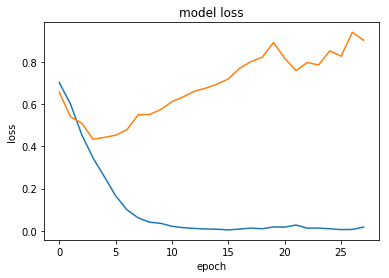

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()